In [3]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import pi


In [4]:
# Define a quantum circuit with 2 qubits: 1 address and 1 embedding
qc = QuantumCircuit(2)

# Apply Hadamard gate to the address qubit (qubit 0)
qc.h(0)

# Apply U1 (rotation around Z-axis) to the embedding qubit (qubit 1)
# Let's assume theta_1 = pi for this example
theta_1 = pi
qc.rz(theta_1, 1)

# For illustration, let's add a CNOT gate to create some entanglement
qc.cx(0, 1)

# Apply measurement to both qubits
qc.measure_all()

# Visualize the circuit
print("Quantum Circuit:")
print(qc.draw())


Quantum Circuit:
          ┌───┐        ░ ┌─┐   
   q_0: ──┤ H ├────■───░─┤M├───
        ┌─┴───┴─┐┌─┴─┐ ░ └╥┘┌─┐
   q_1: ┤ Rz(π) ├┤ X ├─░──╫─┤M├
        └───────┘└───┘ ░  ║ └╥┘
meas: 2/══════════════════╩══╩═
                          0  1 


Measurement Results:
{'00': 526, '11': 498}


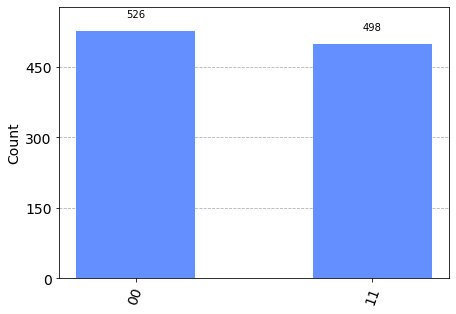

In [5]:
# Simulate the circuit
simulator = Aer.get_backend('qasm_simulator')
new_circuit = transpile(qc, simulator)
job = simulator.run(new_circuit)

# Plot the results
counts = job.result().get_counts(new_circuit)
print("Measurement Results:")
print(counts)
plot_histogram(counts)

In [8]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

# Example adjacency matrix (replace this with your matrix)
A = np.array([[0, 1, 1, 0], [1, 0, 1, 0], [1, 1, 0, 0], [1, 0, 0, 0]])

# Create the graph from the adjacency matrix
G = nx.from_numpy_array(A)

# Draw the graph
nx.draw(G, with_labels=True, node_color='skyblue')
plt.show()

TypeError: '_AxesStack' object is not callable

<Figure size 432x288 with 0 Axes>

In [9]:
import numpy as np
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import pi
import matplotlib.pyplot as plt

# Parameters for the U gates
theta_values = [pi, pi]  # Starting values for theta parameters
rotation_value = pi / 2
backend = Aer.get_backend('qasm_simulator')
num_iterations = 100  # Number of iterations to update parameters
delta = pi/10  # Small change to apply to theta for gradient approximation
learning_rate = 2  # Learning rate for updating theta values
gamma = 0.5  # Example value for gamma, sets the penalty for wrongful node connection
objective_values = [] # Store your objective values in a list to plot them later



# Assuming A is given
# A = np.array([[0, 1, 0, 0], [1, 0, 1, 0], [0, 1, 0, 1], [0, 0, 1, 0]])  # Example adjacency matrix

# Define your quantum circuit as a function to easily recreate it with new theta values
def create_circuit(theta_values):
    qc = QuantumCircuit(3, 2)
    for i in range(2):
        qc.h(i)
    for i, t_val in enumerate(theta_values):
        qc.cry(t_val, i, 2)  # i is the control qubit, 2 is the target qubit
    qc.x(1)
    qc.cx(0, 1)
    qc.cx(1, 2)
    for i in range(2):
        qc.ry(rotation_value, i)
    qc.measure([0,1], [0,1])
    return qc

# print(qc.draw())

def calculate_gradient(A, theta_values, qc, backend, delta):
    gradients = []
    # Calculate objective for theta
    qc = create_circuit(theta_values)
    job = backend.run(transpile(qc, backend))
    L = calculate_objective(A, job.result().get_counts(qc))
    objective_values.append(L)

    for i in range(len(theta_values)):
        # Create circuits for theta + delta and theta - delta
        theta_plus_delta = theta_values.copy()
        theta_plus_delta[i] += delta
        theta_minus_delta = theta_values.copy()
        theta_minus_delta[i] -= delta
        
        # Calculate objective for theta + delta
        qc_plus = create_circuit(theta_plus_delta)
        job_plus = backend.run(transpile(qc_plus, backend))
        L_plus = calculate_objective(A, job_plus.result().get_counts(qc_plus))
        
        # Calculate objective for theta - delta
        qc_minus = create_circuit(theta_minus_delta)
        job_minus = backend.run(transpile(qc_minus, backend))
        L_minus = calculate_objective(A, job_minus.result().get_counts(qc_minus))
        
        # Estimate gradient
        gradient = (L_minus - L_plus) / (2 * delta)
        gradients.append(gradient)
        
    return gradients

def calculate_objective(A, counts):
    N = 2  # Number of qubits used for addressing
    total_shots = sum(counts.values())

    # calculate probabilities
    state_00 = '0' * N  # adjust based on your addressing scheme
    state_11 = '1' * N
    prob_00 = counts.get(state_00, 0) / total_shots
    prob_11 = counts.get(state_11, 0) / total_shots

    num_connections = 0
    num_missing_connections = 0

    # Iterate over all possible states to compute probabilities
    for i in range(len(A)):
        for j in range(len(A[i])):
            # Skip self-connections
            if i == j:
                continue
            
            # Compute objective component for A_ij
            if A[i, j] == 1:
                num_connections += 1
            else:
                num_missing_connections += 1

    L = (num_connections - gamma * num_missing_connections) * (prob_00 + prob_11)

    # TODO probabilities converge to 0

    # Normalize the objective to be between -1 and 1
    max_possible_value = len(A) * (len(A) - 1) / 2  # Simplistic assumption of full connectivity

    # TODO why divide by 2
    L = (2 * L) / max_possible_value - 1

    return L



for iteration in range(num_iterations):
    qc = create_circuit(theta_values)
    print(qc.draw())

    transpiled_qc = transpile(qc, backend)
    job = backend.run(transpiled_qc)
    result = job.result()
    counts = result.get_counts(qc)
    
    # Update theta_values based on calculated gradient
    gradients = calculate_gradient(A, theta_values, qc, backend, delta)
    theta_values = [theta - learning_rate * grad for theta, grad in zip(theta_values, gradients)]
    
    print(f"Iteration {iteration+1}: Theta values = {theta_values}")


     ┌───┐                            ┌─────────┐           ┌─┐   
q_0: ┤ H ├────■────────────────────■──┤ Ry(π/2) ├───────────┤M├───
     ├───┤    │             ┌───┐┌─┴─┐└─────────┘┌─────────┐└╥┘┌─┐
q_1: ┤ H ├────┼────────■────┤ X ├┤ X ├─────■─────┤ Ry(π/2) ├─╫─┤M├
     └───┘┌───┴───┐┌───┴───┐└───┘└───┘   ┌─┴─┐   └─────────┘ ║ └╥┘
q_2: ─────┤ Ry(π) ├┤ Ry(π) ├─────────────┤ X ├───────────────╫──╫─
          └───────┘└───────┘             └───┘               ║  ║ 
c: 2/════════════════════════════════════════════════════════╩══╩═
                                                             0  1 
Iteration 1: Theta values = [3.006373121861327, 3.0483378041218856]
     ┌───┐                                      ┌─────────┐           ┌─┐   
q_0: ┤ H ├──────■────────────────────────────■──┤ Ry(π/2) ├───────────┤M├───
     ├───┤      │                     ┌───┐┌─┴─┐└─────────┘┌─────────┐└╥┘┌─┐
q_1: ┤ H ├──────┼─────────────■───────┤ X ├┤ X ├─────■─────┤ Ry(π/2) ├─╫─┤M├
     └───┘┌─────┴────

Measurement Results:
{'01': 1, '00': 536, '11': 487}


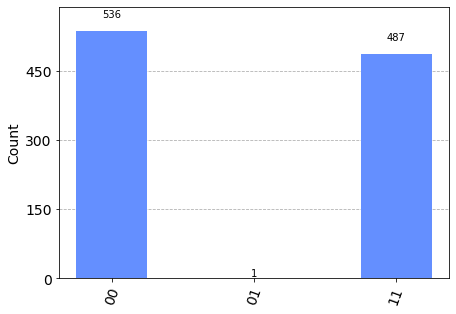

In [11]:
print("Measurement Results:")
print(counts)
plot_histogram(counts)

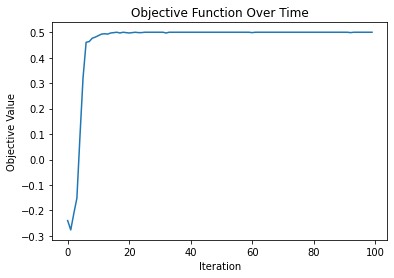

In [12]:
# After all iterations, plot the objective values
plt.plot(objective_values)
plt.xlabel('Iteration')
plt.ylabel('Objective Value')
plt.title('Objective Function Over Time')
plt.show()